# Otimização Bayesiana de Hiperparâmetros

Enquanto os parâmetros de um modelo são aprendidos durante o treinamento, os hiperparâmetros devem ser definidos pelo cientista de antemão. O objetivo do cientista é encontrar o conjunto de hiperparâmetros que minimize o erro do modelo.

A otimização dos hiperparâmetros pode ser representada pela seguinte equação: $x^{\star} = \underset{x \in X}{\operatorname{argmin}} f(x)$ 

$f(x)$ reprsenta a função que deve ser minimizada, a qual chamaremos de função objetivo,  e $x^{\star}$ representa o conjunto de hiperparâmetros ótimo, ou seja, aquele que retorna o menor valor da função objetivo. 

## Abordagens para otimização de hiperparâmetros

Existem diferentes abordagens para otimizar os hiperparâmetros de um modelo. Entre as principais estão o Grid Search (que consiste em testar todas as combinações de hiperparâmetros possíveis à partir de valores pré-definidos) e o Random Search (que testa valores randomicos dentro de um intervalo). As abordagens de Grid Search e Random Search se assemelham pelo fato de não utilizarem as tentativas anteriores para escolher o próximo conjunto de hiperparâmetros a ser testado. Isso traz ineficiência pois gasta-se muito tempo testando conjuntos de hiperparâmetros de baixo potencial.

A __otimização bayesiana__ se destaca pois mantém registros das avaliações de hiperparâmetros passadas e utiliza essa informação para escolher o próximo conjunto de forma inteligente. Para que essa busca seja possível, a otimização bayesiana cria um modelo de probabilidade mapeando os hiperparâmetros às probabilidades de resultado da função objetivo, $P(resultado|Hiperparâmetros)$. Este modelo é chamado de função substituta e é mais fácil de ser otimizado do que a função objetivo. 

A abordagem bayesiana funciona seguindo os seguintes passos:

1. Construção de um modelo de probabilidade mapeando os hiperparêmtros ao resultado da função objetivo (função substituta);
2. Seleção do conjunto de hiperparâmetros de melhor performance na função substituta;
3. Cálculo do resultado da função objetivo utilizando o conjunto de hiperparâmetros escolhido;
4. Atualização da função substituta incorporando os novos resultados;
5. Repete-se os passos 2 a 4 até que o limite de tempo ou iterações seja atingido.

Quanto mais conjuntos de hiperparâmetros são testados, mais parecidas ficam as funções objetivo e substituta. 

<img src="https://www.researchgate.net/profile/Erich_Wehrle/publication/241715938/figure/fig4/AS:457079128367107@1485987564472/Surrogate-modelling-for-a-one-variable-function-with-insufficient-sample-size.png" width="400">

In [1]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import xgboost
from matplotlib import pyplot as plt

df = pd.read_csv('house_sales.csv')
X_train, X_test, y_train, y_test = train_test_split(df.drop('price', axis=1), 
                                                    df.price,
                                                    test_size=0.2)

## Sequential Model-Based Optimization

Os métodos conhecidos como Sequential model-based optimization ou SMBO, são implementações do pensamento bayesiano na otimização de hiperparâmetros. Embora existam diferentes métodos, todos eles apresentam 5 aspectos-chave:

1. Espaço amostral da busca;
2. Função objetivo;
3. Função substituta;
4. Critério de seleção;
5. Histórico de observações.

A forma como se constrói a função substituta é o que mais diferencia os métodos de SMBO. Os modelos mais utilizados são Gaussian Processes, Random Forest Regressions e Tree Parzen Estimators (TPE). 

Vamos passar por cada um dos itens acima utilizando a biblioteca Hyperopt.

In [2]:
# importando funções do hyperopt
from hyperopt import fmin, hp, tpe, Trials, pyll, rand

### Espaço Amostral

Enquanto o espaço amostral para Grid Search é composto por valores específicos, numa abordagem SMBO, utiliza-se distribuições de probabilidade para cada parâmetro. Por exemplo:

<img src="https://cdn-images-1.medium.com/max/400/1*YfoPLKK8_WXIsRaQ7zcSjg.png" width="300" align="left"/><img src="https://cdn-images-1.medium.com/max/400/1*e6cIETdFd1rzD9ivofNJqw.png" width="300" />

Utilizando o Hyperopt, o espaço amostral pode ser definido da seguinte forma:

In [3]:
space ={'n_estimators': hp.quniform('n_estimators', 100, 1000, 1),
        'eta': hp.uniform('eta', 0.01, 0.5),
        'max_depth' : hp.qlognormal("max_depth", 1, 0.9, 1),
        'subsample': hp.quniform('subsample', 0.5, 1.0, 0.01),
        'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1.0, 0.05)}

In [4]:
def get_samples(param, n_samples):
    return [pyll.stochastic.sample(space[param]) for i in range(n_samples)]

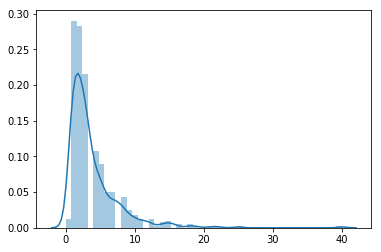

In [5]:
sns.distplot(get_samples('max_depth', 500));

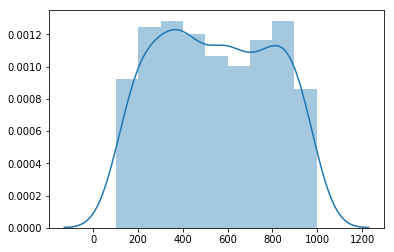

In [6]:
sns.distplot(get_samples('n_estimators', 500));

### Função Objetivo

A função objetivo deve receber um conjnto de hiperparâmetros e retornar um valor. Isso significa que devemos definir, treinar e aplicar nosso modelo dentro da função objetivo. Em nosso exemplo, o valor retornado será minimizado nos próximos passos, portanto retornaremos 1 - o KS.

A função objetivo do hyperopt pode retornar somente um valor ou então um dicionário. Caso retorne um dicioário, [a biblioteca exige que este contenha as chaves status e loss.](https://github.com/hyperopt/hyperopt/wiki/FMin)

In [18]:
def score(params):
    params['n_estimators'] = int(params['n_estimators'])
    params['max_depth'] = int(params['max_depth']) + 1
    
    xgb_model = xgboost.XGBRegressor(**params)        
    
    scores = cross_val_score(xgb_model, X_train, y_train, cv=3,
                             scoring='neg_mean_absolute_error')
    return scores.mean()


Note que a função objetivo será tratada pelo hyperopt como uma caixa-preta, ou seja, dentro dela podemos inserir o que quisermos, incluindo parâmetros do modelo, parâmetros de treino e até mesmo scripts para salvar os scores em disco durante o processo.

### Função substituta & Critério de Seleção

A ideia por trás da otimização bayesiana é chegar em um resultado ótimo mais rapidamente através de uma busca inteligente, testando o conjunto de paramêtros mais promissor a cada iteração. A seleção do conjunto mais promissor se baseia na função substituta. 

Além de modelar a distribuição dos scores, precisamos também de um critério para seleção do conjunto de hiperparâmetros. Este critério deve buscar um equilíbrio entre __Exploration__ e __Exploitation__, ou seja, queremos testar os parâmetros que nos parecem mais promissores, mas também queremos explorar o espaço amostral para construir uma base de conhecimento acerca dos efeitos dos hiperparâmetros em diferentes regiões do espaço amotral. 

<img src="https://blogs.sas.com/content/subconsciousmusings/files/2019/05/bayesian04.gif" width="500">

#### TPE

O Hyperopt utiliza o método TPE para modelar a função substituta e o Incremento Esperado (Expected Improvement) critério de seleção.

O algoritmo inicia a busca testando conjuntos de parâmetros aleatórios seguindo as distribuições do espaço amostral sugerido e após coletar alguns resultados iniciais, os conjuntos de hiperparâmetros é dividido entre em dois grupos: bons (cerca de 20% a 25%) e maus (todo o restante).

<img src="http://dkopczyk.quantee.co.uk/wp-content/uploads/2018/03/tpe_good_bad.png" width="500">

Para cada grupo (bons e maus), cria-se uma função de densidade utilizando o método da janela de Parzen-Rosenblatt, mais conhecido como Estimativa de Densidade Kernal (KDE). 

O KDE modela as densidades dos hiperparâmetros de maneira empírica (não paramétrica): cada observação dá origem a uma distribuição Gaussiana, com média igual ao valor dos hiperparâmetros. Essas distribuição são então combinadas (empilhadas e normalizadas) e dão origem às distribuições dos conjuntos de hiperparâmetros bons e maus.

<img src="http://dkopczyk.quantee.co.uk/wp-content/uploads/2018/03/tpe_parzen.png" width="600">

As duas distribuições são utilizadas para se calcular a Expectativa de Incremento, que se dá por 
<font size="4">$ EI(h) = \frac{Pr^{bons}(h)}{Pr^{maus}(h)} $ </font>, onde $Pr^{bons}$ é a probabilidade de se pertencer ao grupo dos bons hiperparâmetros e $Pr^{maus}$ é a probabilidade de se pertencer ao grupo dos parâmetros ruins.

<img src="http://dkopczyk.quantee.co.uk/wp-content/uploads/2018/03/tpe_ei.png" width="600">

O conjunto de hiperparâmetros selecionado para ser testado em seguida é aquele com maior retorno esperado (EI), dentro do espaço amostral inicial. 

Note que o critério de seleção do 
TPE dá prioridade a _Exploitation_ em detrimento de _Exploration_:

<img src="https://cdn-images-1.medium.com/max/1200/1*m1JYCHHhbmn6TCHcJIklZA.gif" width="500">

Com o Hyperopt podemos utilizar o TPE através da função ```tpe.suggest```, dentro da função ```fmin()```, que além do critério de busca, requer a função objetivo, o espaço amostral e a quantidade máxima de iterações. Como no examplo a seguir:

In [19]:
best_hp = fmin(score, space, algo=tpe.suggest, max_evals=10)

100%|██████████| 10/10 [04:50<00:00, 20.39s/it, best loss: -82526.6290377018]


In [20]:
best_hp

{'colsample_bytree': 1.0,
 'eta': 0.19111692540021388,
 'max_depth': 1.0,
 'n_estimators': 600.0,
 'subsample': 0.8}

### Histórico de observações

O Hyperopt disponibiliza o objeto Trials para facilitar o acesso às informações das iterações. Incluindo o objeto na função de busca, podemos analisar todos os parâmetros testados, os scores retornados e também salvar o espaço amostral explorado para retomar a busca em um segundo momento.

In [21]:
trials = Trials()
best_hp = fmin(score, space, algo=tpe.suggest, max_evals=100, trials = trials)

100%|██████████| 100/100 [20:51<00:00, 12.06s/it, best loss: -116285.53484100413]


O atributo ```best_trial``` retorna os dados da iteração com melhor score:

In [22]:
trials.best_trial

{'state': 2,
 'tid': 39,
 'spec': None,
 'result': {'loss': -116285.53484100413, 'status': 'ok'},
 'misc': {'tid': 39,
  'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'workdir': None,
  'idxs': {'colsample_bytree': [39],
   'eta': [39],
   'max_depth': [39],
   'n_estimators': [39],
   'subsample': [39]},
  'vals': {'colsample_bytree': [0.6000000000000001],
   'eta': [0.33129821352633804],
   'max_depth': [0.0],
   'n_estimators': [100.0],
   'subsample': [0.71]}},
 'exp_key': None,
 'owner': None,
 'version': 0,
 'book_time': datetime.datetime(2019, 6, 14, 13, 22, 56, 40000),
 'refresh_time': datetime.datetime(2019, 6, 14, 13, 22, 57, 701000)}

Com o método ```losses()``` conseguimos visualizar o score de cada iteração:

(Text(0.5, 1.0, 'Custo da função objetivo a cada iteração'),)

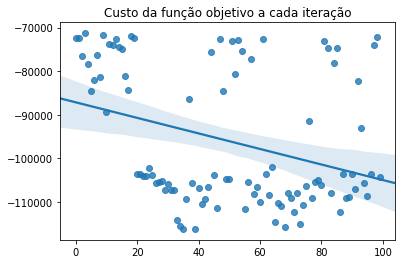

In [23]:
losses = pd.Series(trials.losses())
sns.regplot(x=losses.index.tolist() ,y=losses.values);
plt.title('Custo da função objetivo a cada iteração'),

A informação completa dos testes pode ser acessada através do atributo ```trials```. A função ```make_trials_df``` transforma essa informação em um DataFrame do Pandas.

In [24]:
def make_trials_df(trials_ob):
    params_tried = [trial['misc']['vals'] for trial in trials_ob.trials]
    return pd.DataFrame(params_tried).applymap(lambda x:x[0])
    
params_tried = make_trials_df(trials)
params_tried.head()

,colsample_bytree,eta,max_depth,n_estimators,subsample
0,0.95,0.205475,5.0,909.0,0.64
1,0.70,0.283329,3.0,919.0,0.93
2,0.65,0.446711,35.0,519.0,0.71
3,0.80,0.280977,5.0,513.0,0.88
4,0.65,0.412392,3.0,169.0,0.56


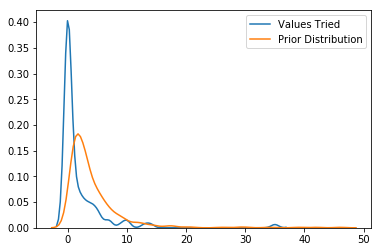

In [25]:
sns.kdeplot(params_tried['max_depth'], label='Values Tried');
sns.kdeplot(get_samples('max_depth', 500), label='Prior Distribution');

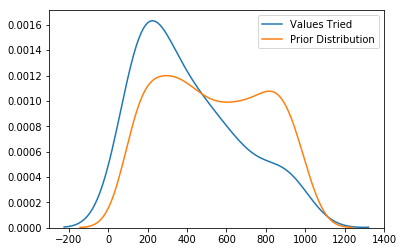

In [26]:
sns.kdeplot(params_tried['n_estimators'], label='Values Tried');
sns.kdeplot(get_samples('n_estimators', 500), label='Prior Distribution');

### Comparação de resultados

In [27]:
max_evals = 300

tpe_trials = Trials()
rse_trials = Trials()

tpe_hp = fmin(score, space, algo=tpe.suggest, max_evals=max_evals, trials=tpe_trials)
rse_hp = fmin(score, space, algo=rand.suggest, max_evals=max_evals, trials=rse_trials)

100%|██████████| 300/300 [1:44:24<00:00, 29.49s/it, best loss: -113110.4178882612]  


In [28]:
print('Erro da melhor iteração com TPE: {}'.format(round(tpe_trials.best_trial['result']['loss'])))
print('Erro da melhor iteração com Random Search: {}'.format(round(rse_trials.best_trial['result']['loss'])))

Erro da melhor iteração com TPE: -116886
Erro da melhor iteração com Random Search: -113110


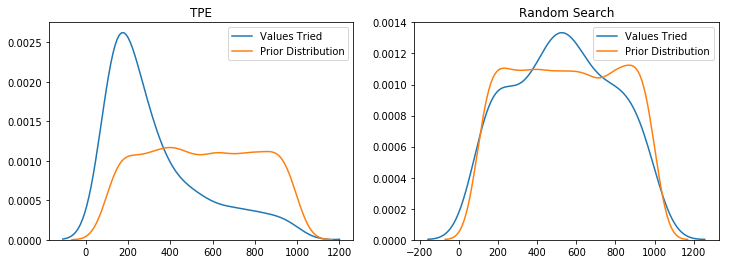

In [29]:
param = 'n_estimators'
n_samples = 3000

fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_figwidth(12)

ax1.title.set_text('TPE')
tpe_params = make_trials_df(tpe_trials)
sns.kdeplot(tpe_params[param], label='Values Tried', ax=ax1);
sns.kdeplot(get_samples(param, n_samples), label='Prior Distribution', ax=ax1);

ax2.title.set_text('Random Search')
rse_params = make_trials_df(rse_trials)
sns.kdeplot(rse_params[param], label='Values Tried', ax=ax2);
sns.kdeplot(get_samples(param, n_samples), label='Prior Distribution', ax=ax2);

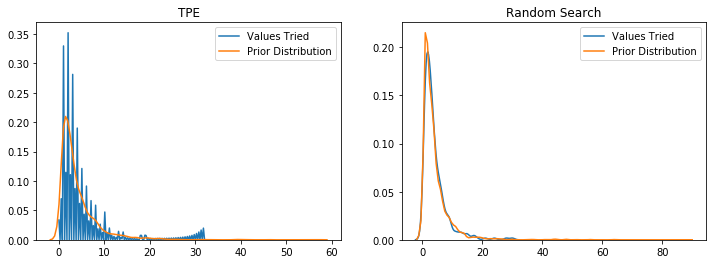

In [30]:
param = 'max_depth'
n_samples = 3000

fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_figwidth(12)

ax1.title.set_text('TPE')
tpe_params = make_trials_df(tpe_trials)
sns.kdeplot(tpe_params[param], label='Values Tried', ax=ax1);
sns.kdeplot(get_samples(param, n_samples), label='Prior Distribution', ax=ax1);

ax2.title.set_text('Random Search')
rse_params = make_trials_df(rse_trials)
sns.kdeplot(rse_params[param], label='Values Tried', ax=ax2);
sns.kdeplot(get_samples(param, n_samples), label='Prior Distribution', ax=ax2);

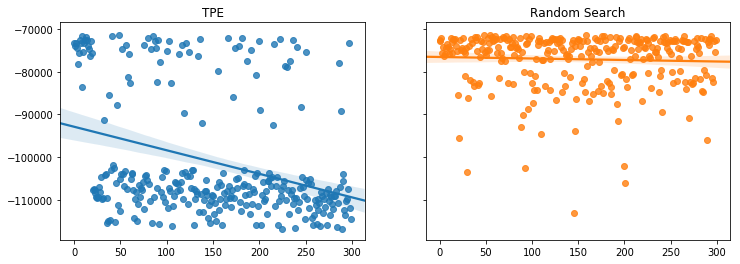

In [31]:
fig, (ax1, ax2) = plt.subplots(1,2, sharey=True)
fig.set_figwidth(12)

ax1.title.set_text('TPE')
tpe_losses = pd.Series(tpe_trials.losses())
sns.regplot(x=tpe_losses.index.tolist() ,y=tpe_losses.values, ax=ax1);

ax2.title.set_text('Random Search')
rse_losses = pd.Series(rse_trials.losses())
sns.regplot(x=rse_losses.index.tolist() ,y=rse_losses.values, ax=ax2);

Referências
- https://github.com/hyperopt/hyperopt
- https://www.cs.ox.ac.uk/people/nando.defreitas/publications/BayesOptLoop.pdf
- https://medium.com/criteo-labs/hyper-parameter-optimization-algorithms-2fe447525903
- https://towardsdatascience.com/automated-machine-learning-hyperparameter-tuning-in-python-dfda59b72f8a
- https://towardsdatascience.com/an-introductory-example-of-bayesian-optimization-in-python-with-hyperopt-aae40fff4ff0
- http://dkopczyk.quantee.co.uk/hyperparameter-optimization/
- https://towardsdatascience.com/a-conceptual-explanation-of-bayesian-model-based-hyperparameter-optimization-for-machine-learning-b8172278050f
- https://medium.com/vooban-ai/hyperopt-tutorial-for-optimizing-neural-networks-hyperparameters-e3102814b919